# DLPY Time Series RNN

The National Centers for Environmental Information (NCEI) provides public access to environmental data archives. The data set **DURHAM** contains hourly weather information for the city of Durham, North Carolina from 2008 to 2017, approximately 90,000 observations. The goal is to use a recurrent neural network to forecast the maximum hourly temperature in Durham, North Carolina.  

| Name       | Model Role | Measurement Level | Description                                                            |
|:-----------|:-----------|:------------------|:-----------------------------------------------------------------------|
| LST_DATE   | Date       | Date              | Date of each observation in YYYYMMDD format                            |
| LST_TIME   | Input      | Nominal           | Hour of the observation (0-2300 by 100)                                |
| T_MAX      | Target     | Interval          | Maximum air temperature in degrees C during the hour                   |
| P_CALC     | Input      | Interval          | Total amount of percipitation in mm during the hour                    |

# Load Packages

In [1]:
import swat
import pandas as pd
import datetime
from matplotlib import pyplot as plt
%matplotlib inline
swat.options.cas.print_messages = True
import dlpy
from dlpy import Model, Sequential, TimeseriesTable
from dlpy.layers import *
from dlpy.applications import *
from dlpy.timeseries import plot_timeseries
from dlpy.model import Optimizer, AdamSolver, Sequence, DLPyDict

# Connect to CAS

In [2]:
conn = swat.CAS("server", 30571, "student", "Metadata0")

# Load Data onto the Server

In [3]:
durham_tbl = TimeseriesTable.from_localfile(conn, path="D:\Workshop\Winsas\VOSI\durham_v2.csv", 
                                            casout=dict(name="durham", replace=True))

NOTE: Cloud Analytic Services made the uploaded file available as table DURHAM in caslib CASUSER(student).
NOTE: The table DURHAM has been created in caslib CASUSER(student) from binary data uploaded to Cloud Analytic Services.


In [4]:
durham_tbl.head()

,LST_DATE,LST_TIME,T_MAX,P_CALC,year,month,day,hour,datetime,day_of_year,sin_day_of_year,cos_day_of_year,sin_Hr,cos_Hr
0,20160929.0,400.0,18.1,0.0,2016.0,9.0,29.0,4.0,2016-09-29 04:00:00,273.0,-0.99987,-0.016127,0.866025,5.000000e-01
1,20160929.0,500.0,18.0,0.0,2016.0,9.0,29.0,5.0,2016-09-29 05:00:00,273.0,-0.99987,-0.016127,0.965926,2.588190e-01
2,20160929.0,600.0,17.9,0.0,2016.0,9.0,29.0,6.0,2016-09-29 06:00:00,273.0,-0.99987,-0.016127,1.000000,6.123234e-17
3,20160929.0,700.0,17.9,0.0,2016.0,9.0,29.0,7.0,2016-09-29 07:00:00,273.0,-0.99987,-0.016127,0.965926,-2.588190e-01
4,20160929.0,800.0,18.5,0.0,2016.0,9.0,29.0,8.0,2016-09-29 08:00:00,273.0,-0.99987,-0.016127,0.866025,-5.000000e-01


# Formatting

In [5]:
timeseries_list = ['T_MAX','P_CALC','sin_Hr','cos_Hr', 'sin_day_of_year','cos_day_of_year']
durham_tbl.timeseries_formatting(timeid='datetime',timeseries=timeseries_list, extra_columns=[], timeid_informat='anydtdtm19.')

NOTE: Timeseries formatting is completed.


# Accumulate Time Series

In [6]:
durham_tbl.timeseries_accumlation(acc_interval='hour', acc_method_byvar={'T_MAX':'max', 
                                                                         'sin_Hr':'avg',
                                                                         'cos_Hr':'avg',
                                                                        'sin_day_of_year':'avg', 
                                                                        'cos_day_of_year':'avg'})

NOTE: Added action set 'timeData'.
NOTE: Timeseries are accumulated to the frequency of hour


# Prepare Subsequences

In [7]:
durham_tbl.prepare_subsequences(seq_len=5, target='T_MAX', predictor_timeseries=timeseries_list)

NOTE: timeseries subsequences are prepared with subsequence length = 5


In [8]:
durham_tbl.head()

,datetime,T_MAX,P_CALC,sin_Hr,cos_Hr,sin_day_of_year,cos_day_of_year,P_CALC_lag1,P_CALC_lag2,P_CALC_lag3,...,cos_day_of_year_lag2,cos_day_of_year_lag3,cos_day_of_year_lag4,T_MAX_lag1,T_MAX_lag2,T_MAX_lag3,T_MAX_lag4,T_MAX_lag5,xlen,ylen
0,2008-01-01 01:00:00,6.7,0.0,0.258819,0.965926,0.017202,0.999852,0.0,0.0,0.0,...,0.999991,0.999991,0.999991,6.5,6.9,7.2,7.7,6.8,5.0,1.0
1,2008-01-01 02:00:00,5.8,0.0,0.500000,0.866025,0.017202,0.999852,0.0,0.0,0.0,...,0.999852,0.999991,0.999991,6.7,6.5,6.9,7.2,7.7,5.0,1.0
2,2008-01-01 03:00:00,5.1,0.0,0.707107,0.707107,0.017202,0.999852,0.0,0.0,0.0,...,0.999852,0.999852,0.999991,5.8,6.7,6.5,6.9,7.2,5.0,1.0
3,2008-01-01 04:00:00,5.4,0.0,0.866025,0.500000,0.017202,0.999852,0.0,0.0,0.0,...,0.999852,0.999852,0.999852,5.1,5.8,6.7,6.5,6.9,5.0,1.0
4,2008-01-01 05:00:00,4.7,0.0,0.965926,0.258819,0.017202,0.999852,0.0,0.0,0.0,...,0.999852,0.999852,0.999852,5.4,5.1,5.8,6.7,6.5,5.0,1.0


# Partition the Data

In [9]:
validation_start = datetime.date(2017,1,1)
testing_start = datetime.date(2017,11,1)
train_tbl, valid_tbl, test_tbl = durham_tbl.timeseries_partition(validation_start=validation_start, testing_start=testing_start)

NOTE: Training set has 78678 observations
NOTE: Validation set has 7223 observations
NOTE: Testing set has 1432 observations


# Build the Model

In [10]:
simple_lstm = Sequential(conn, model_table='simple_cnn')
simple_lstm.add(InputLayer(std="std"))
simple_lstm.add(Recurrent(rnn_type="lstm", n=15, init="xavier", output_type="samelength"))
simple_lstm.add(Recurrent(rnn_type="lstm", n=15, init="xavier", output_type="encoding"))
simple_lstm.add(OutputLayer(act="identity"))

NOTE: Input layer added.
NOTE: Recurrent layer added.
NOTE: Recurrent layer added.
NOTE: Output layer added.
NOTE: Model compiled successfully.


In [11]:
simple_lstm.get_model_info()

,Descr,Value
0,Model Name,simple_cnn
1,Model Type,Recurrent Neural Network
2,Number of Layers,4
3,Number of Input Layers,1
4,Number of Output Layers,1
5,Number of Convolutional Layers,0
6,Number of Pooling Layers,0
7,Number of Fully Connected Layers,0
8,Number of Recurrent Layers,2


In [12]:
simple_lstm.print_summary()

,Layer Id,Layer,Type,Activation,Output Size
0,0,Input1,input,None,0
1,1,Rec.1,recurrent,Auto,15
2,2,Rec.2,recurrent,Auto,15
3,3,Output1,output,Identity,None


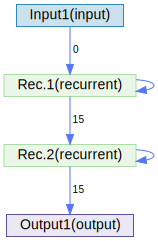

In [13]:
simple_lstm.plot_network()

# Train the Model

In [14]:
optimizer = Optimizer(algorithm=AdamSolver(learning_rate=0.01), mini_batch_size=32, seed=1234, max_epochs=50)                   
seq_spec  = Sequence(**train_tbl.sequence_opt)
result = simple_lstm.fit(train_tbl, valid_table=valid_tbl, optimizer=optimizer, sequence=seq_spec, **train_tbl.inputs_target)

NOTE: Training from scratch.


# Score the Model

In [15]:
scored_info = simple_lstm.predict(test_tbl)
scored_table = scored_info['OutputCasTables']['Name'][0]
scored_info['ScoreInfo']

,Descr,Value
0,Number of Observations Read,1432
1,Number of Observations Used,1432
2,Mean Squared Error,0.601747
3,Loss Error,0.300874


# Analyze Results Locally

In [16]:
df = conn.CASTable(name=scored_table)
df = df.to_frame()
display(df.head())
df.shape

,datetime,T_MAX,P_CALC,sin_Hr,cos_Hr,sin_day_of_year,cos_day_of_year,P_CALC_lag1,P_CALC_lag2,P_CALC_lag3,...,cos_day_of_year_lag4,T_MAX_lag1,T_MAX_lag2,T_MAX_lag3,T_MAX_lag4,T_MAX_lag5,xlen,ylen,split_id,_DL_Pred_
0,2017-11-01 00:00:00,7.5,0.0,0.000000,1.000000,-0.8606,0.509282,0.0,0.0,0.0,...,0.494403,7.9,8.7,9.6,11.2,12.6,5.0,1.0,test,7.350939
1,2017-11-01 01:00:00,6.9,0.0,0.258819,0.965926,-0.8606,0.509282,0.0,0.0,0.0,...,0.494403,7.5,7.9,8.7,9.6,11.2,5.0,1.0,test,7.174779
2,2017-11-01 02:00:00,6.5,0.0,0.500000,0.866025,-0.8606,0.509282,0.0,0.0,0.0,...,0.494403,6.9,7.5,7.9,8.7,9.6,5.0,1.0,test,6.593699
3,2017-11-01 03:00:00,6.3,0.0,0.707107,0.707107,-0.8606,0.509282,0.0,0.0,0.0,...,0.494403,6.5,6.9,7.5,7.9,8.7,5.0,1.0,test,6.269394
4,2017-11-01 04:00:00,6.1,0.0,0.866025,0.500000,-0.8606,0.509282,0.0,0.0,0.0,...,0.509282,6.3,6.5,6.9,7.5,7.9,5.0,1.0,test,6.169186


(1432, 36)

In [17]:
print('Average absolute error = ' + str(round(abs(df['T_MAX']- df['_DL_Pred_']).mean(),4)))

Average absolute error = 0.5322


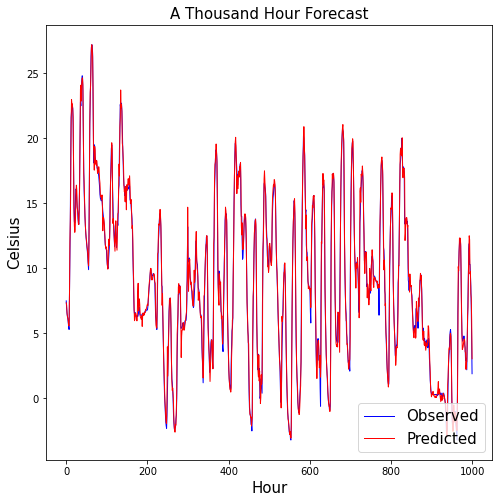

In [18]:
plt.figure(figsize=(8,8))
plt.plot(df['T_MAX'][:1000], color='blue', linewidth=1, label='Observed')
plt.plot(df['_DL_Pred_'][:1000], color='red', linewidth=1, label='Predicted')
plt.title('A Thousand Hour Forecast', fontsize=15)
plt.xlabel('Hour', fontsize=15)
plt.ylabel('Celsius', fontsize=15)
plt.legend(loc='lower right', fontsize=15)
plt.show()

# End the Session

In [19]:
conn.session.endSession()

+ Elapsed: 0.0002s, user: 0.000187s, mem: 0.222mb